# Laboratorium 3

### Konfiguracja

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [6]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


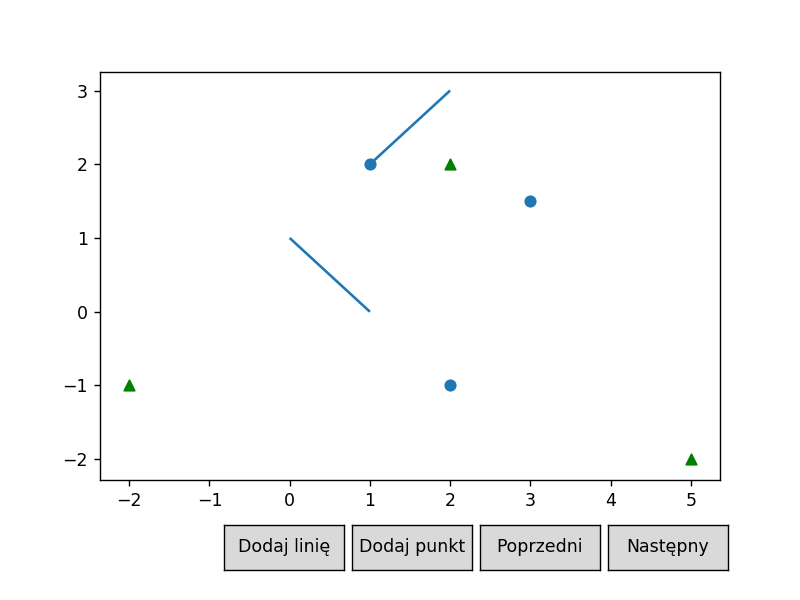

In [7]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


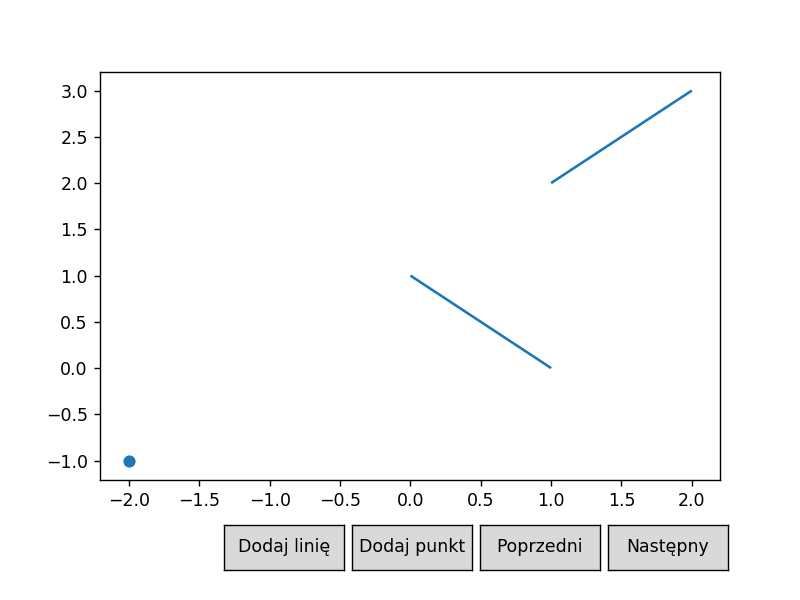

In [8]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


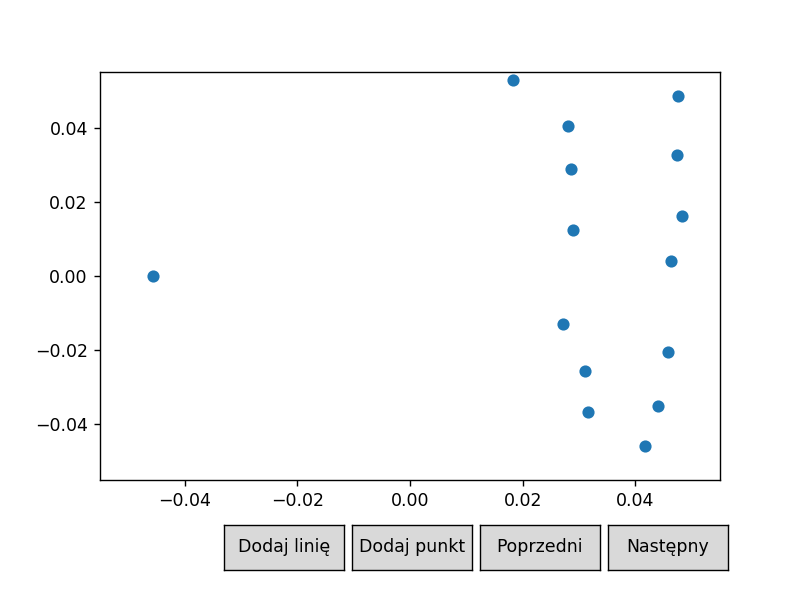

In [10]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

In [11]:
addedLines = [ [ (100 * x[0][0],100 * x[0][1]),(100 * x[1][0],100 * x[1][1]) ] for x in plot1.get_added_elements().lines[0].lines]
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

IndexError: list index out of range

## Write to file

In [12]:
def writeToFile(lines, fileName):
    scene = Scene([],[LinesCollection(lines)])
    plot = Plot([scene])
    
    with open(fileName, 'w') as file:
        file.write(plot.toJson())

# we get lines from file

def readLines(fileName):
    with open(fileName, 'r') as file:
        json = file.read()
        plot = Plot(json=json)
    return plot.scenes[0].lines[0].lines

### Solution

In [23]:
#generating random lines
def oneLine(minCoord, maxCoord):
    x1 = np.random.uniform(minCoord, maxCoord)
    x2 = np.random.uniform(minCoord, maxCoord)

    minx = min(x1,x2)
    maxx = max(x1,x2)
    return [(minx, np.random.uniform(minCoord, maxCoord)), (maxx, np.random.uniform(minCoord, maxCoord))]
 
def generateLines(linesCount, minCoord, maxCoord, points = []):
    lines = []

    while len(lines) < linesCount:
        line = oneLine(minCoord,maxCoord)
        if line[0] not in points and line[1] not in points:
            if line[0][0] != line[1][0]:
                lines.append(line)
                points.append(line[0])
                points.append(line[1])  
    return lines

<IPython.core.display.Javascript object>


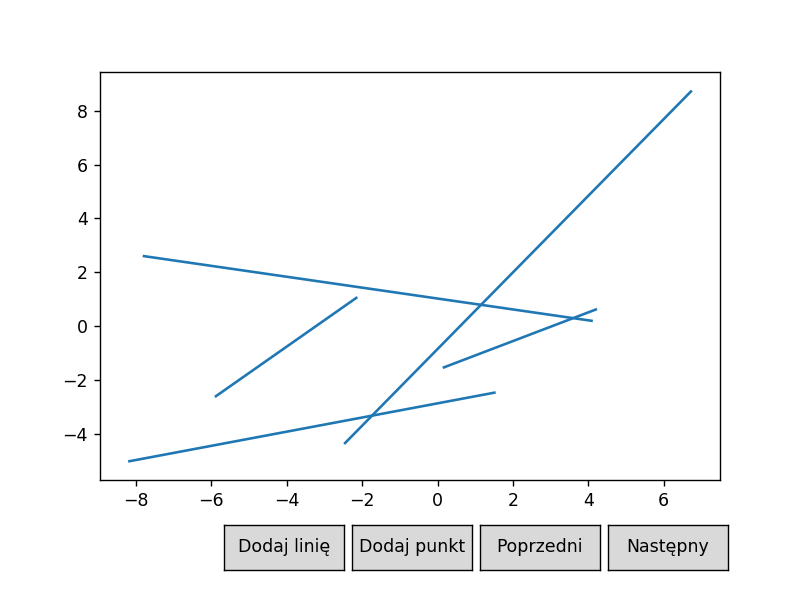

In [24]:
%matplotlib notebook
lines = generateLines(5,-10,10)
plot = Plot([Scene([PointsCollection([])],[LinesCollection(lines)])])
plot.draw()

##  Struktura stanu

## Algorithm implementation 

Event types are as following:
0. start of a line segment
1. intersection
2. end of a line segment

In [25]:
#a bunch of functions used to compute orientation and postion of points and lines
def determiner(a,b,c):
    return a.x*b.y + a.y*c.x + b.x*c.y - a.x*c.y - a.y*b.x - b.y*c.x

def getLineOrientation(point, segment, eps=1e-6):
    orientation = determiner(segment.start, segment.end, point)
    if(orientation < -eps):
        return -1
    elif(orientation > eps):
        return 1
    else:
        return 0

#calculating intersections

def lineCoefficients(p1, p2):
    A = (p1.y - p2.y)
    B = (p2.x - p1.x)
    C = (p1.x*p2.y - p2.x*p1.y)
    return A, B, -C
#check if lines intersect using determinant (if determiner has the same sign for both ends of a segment then it means
# that the whole segment is located on one side of another - there is no intersection)

def doIntersect(segment1, segment2):
    if determiner(segment1.start,segment1.end,segment2.start) * determiner(segment1.start,segment1.end,segment2.end) > 0: return False
    if determiner(segment2.start,segment2.end,segment1.start) * determiner(segment2.start,segment2.end,segment1.end) > 0: return False
    return True

# function that returns the intersection point
def calculateIntersection(segment1, segment2):
    #test if intersect
    if not (doIntersect(segment1,segment2)): return False
    #calculate coefficients of lines
    LineC1 = lineCoefficients(segment1.start,segment1.end)
    LineC2 = lineCoefficients(segment2.start,segment2.end)
    #solving linear equation using Cramers formula
    MainDet  = LineC1[0] * LineC2[1] - LineC1[1] * LineC2[0]
    if MainDet != 0:
        xDet = LineC1[2] * LineC2[1] - LineC1[1] * LineC2[2]
        yDet = LineC1[0] * LineC2[2] - LineC1[2] * LineC2[0]
        x = xDet / MainDet
        y = yDet / MainDet
        return round(x,8),round(y,8)
    return False




In [26]:
#classes used by data structures
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    

    
class Segment:
    def __init__(self, start, end):
        self.start = start
        self.end = end

    def __eq__(self, other):
        return self.end == other.end and self.start == other.start



class StateSegment:
    def __init__(self, segment):
        self.segment = segment
        self.start = segment.start
        self.end = segment.end
        self.orientation_point = self.start
    
    def __lt__(self, other):
        orientation = None
        if self.orientation_point.x >= other.orientation_point.x:
            orientation = getLineOrientation(self.orientation_point, other.segment)
        else:
            orientation = -getLineOrientation(other.orientation_point, self.segment)
        
        return (orientation == 1) or (orientation == 0 and getLineOrientation(self.end, other.segment) == 1)
    
    def __eq__(self, other):
        return self.segment == other.segment


        
class Event:
    def __init__(self, point, segments, event_type):
        self.point = point
        self.segments = segments
        self.type = event_type
    
    def __lt__(self, other):
        return (self.point.x < other.point.x) or (self.point.x == other.point.x and self.point.y < other.point.y) or (self.point.x == other.point.x and self.point.y == other.point.y and self.type < other.type)

    def __eq__(self, other):
        return self.point == other.point and self.type == other.type
    

In [34]:
#helper functions used by different steps of algorithm

def checkNeighbourDelete(event, state):
    
    stateSeg = StateSegment(event.segments)
    
    intersections1 = []
    
    neighbour1 = state.successor(stateSeg)
    neighbour2 = state.predecessor(stateSeg)
    
    state.remove(stateSeg)    
    
    #calculate intersection
    if (not neighbour1 is None) and (not neighbour2 is None):
        intersection_point = calculateIntersection(neighbour1.segment, neighbour2.segment)
        if intersection_point :
            intersections1.append((intersection_point,[neighbour1.segment,neighbour2.segment]))
            
    return intersections1

    
def checkNeighbourInsert(event, state):
    
    stateSeg = StateSegment(event.segments)
    state.insert(stateSeg)
    
    intersections = []
    
    neighbour1 = state.successor(stateSeg)
    neighbour2 = state.predecessor(stateSeg)
    
    #calculate intersection
    if not (neighbour1 is None):
        intersection_point = calculateIntersection(neighbour1.segment, stateSeg.segment)
        if intersection_point :
            intersections.append((intersection_point,[neighbour1.segment,stateSeg.segment]))
            
    if not (neighbour2 is None):
        intersection_point = calculateIntersection(neighbour2.segment, stateSeg.segment)
        if intersection_point:
            intersections.append((intersection_point,[neighbour2.segment,stateSeg.segment]))
      
    return intersections

def CheckNeighbourIntersect(event, state):
    
        intersections1 = []
        # get segments
        stateSeg1 = StateSegment(event.segments[0])
        stateSeg2 = StateSegment(event.segments[1])
        #remove them from structure
        state.remove(stateSeg1)
        state.remove(stateSeg2)
        #change orientation point
        stateSeg1.orientation_point = event.point
        stateSeg2.orientation_point = event.point
        #calculate intersection points of swapped segments
        state.insert(stateSeg1)
        
        neighbour1 = state.successor(stateSeg1)
        neighbour2 = state.predecessor(stateSeg1)
        #calculate intersection
        if not (neighbour1 is None):
            intersection_point = calculateIntersection(neighbour1.segment, stateSeg1.segment)
            if intersection_point :
                intersections1.append((intersection_point,[neighbour1.segment,stateSeg1.segment]))
            
        if not (neighbour2 is None):
            intersection_point = calculateIntersection(neighbour2.segment, stateSeg1.segment)
            if intersection_point:
                intersections1.append((intersection_point,[neighbour2.segment,stateSeg1.segment]))
        
        state.insert(stateSeg2)
        
        neighbour1 = state.successor(stateSeg2)
        neighbour2 = state.predecessor(stateSeg2)
        #calculate intersection
        if not (neighbour1 is None):
            intersection_point = calculateIntersection(neighbour1.segment, stateSeg2.segment)
            if intersection_point :
                intersections1.append((intersection_point,[neighbour1.segment,stateSeg2.segment]))
            
        if not (neighbour2 is None):
            intersection_point = calculateIntersection(neighbour2.segment, stateSeg2.segment)
            if intersection_point:
                intersections1.append((intersection_point,[neighbour2.segment,stateSeg2.segment]))
        
        return intersections1
    



# Algorithm for checking if intersection exists

In [35]:
import tree
#Bentley-Ottoman algorithm that ends on first intersection found - (ecplanation of steps below)
def sweepTillFirstIntersection(lines):

    events = []
    state = tree.RBTree()

    Segments = []
    
    for x in lines:
        Segments.append(Segment(Point(x[0][0], x[0][1]),Point(x[1][0],x[1][1])))    
    
    for segment in Segments:
        events.append(Event(segment.start, segment, 0))
        events.append(Event(segment.end, segment, 2))
        
    events.sort()
    
    while  events:
        
        event = events.pop(0)
        
        if(event.type == 0):

            newIntersections = checkNeighbourInsert(event, state)
            if newIntersections: return True
                        
        elif(event.type == 2):
            
            newIntersections = checkNeighbourDelete(event, state)
            if newIntersections: return True
            
 
    return False

# Algorithm for finding all intersections

In [36]:
import tree

def sweep(lines):
    #initialize data structures
    events = tree.RBTree()
    state = tree.RBTree()

    Segments = []
    #convert lines to segments
    for x in lines:
        Segments.append(Segment(Point(x[0][0], x[0][1]),Point(x[1][0],x[1][1])))    
    #fill event structure with each segment points (start and end)
    for segment in Segments:
        events.insert(Event(segment.start, segment, 0))
        events.insert(Event(segment.end, segment, 2))
        
    #initialize intersection set and getting first event
    intersections = set()
    event = events.minimum()
    events.remove(event)
    
    while(not event is None):
        #start of a segment
        if(event.type == 0):
            #calculating intersection and updating event structure
            newIntersections = checkNeighbourInsert(event, state)
            if newIntersections:
                for x,segs in newIntersections:
                    if not x in intersections:
                        intersections.add(x)
                        events.insert(Event(Point(x[0],x[1]),segs,1))
        #end of a segment            
        elif(event.type == 2):
            
            newIntersections = checkNeighbourDelete(event, state)
            
            if newIntersections:
                for x,segs in newIntersections:
                    if not (x in intersections):
                        intersections.add(x)
                        events.insert(Event(Point(x[0],x[1]),segs,1))
        #intersection point
        else:
            
            newIntersections = CheckNeighbourIntersect(event, state)
            
            if newIntersections:
                for x,segs in newIntersections:
                    if not (x in intersections):
                        intersections.add(x)
                        events.insert(Event(Point(x[0],x[1]),segs,1))
                        
            
        events.remove(event)
        event = events.minimum()
            
    return intersections


True


<IPython.core.display.Javascript object>


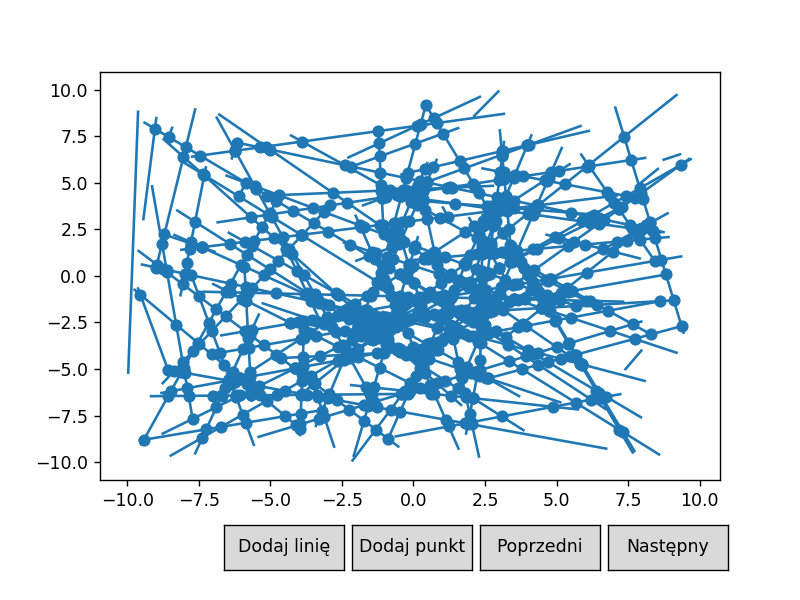

In [37]:
lines = generateLines(100,10,-10)

points2 = sweep(lines)
points2 = list(points2)
print(sweepTillFirstIntersection(lines))

plot = Plot([Scene([PointsCollection(points2)],[LinesCollection(lines)])])
plot.draw()

In [367]:
# Visualization of an algorithm

In [38]:
import tree
import copy

def sweepVisualize(lines):
    
    Segments = []
    
    minY = float("Inf")
    maxY = -float("Inf")
    
    for x in lines:
        if x[0][1] < minY:
            minY = x[0][1]
        elif x[0][1] > maxY:
            maxY = x[0][1]
        if x[1][1] < minY:
            minY = x[1][1]
        elif x[1][1] > maxY:
            maxY = x[1][1]
        Segments.append(Segment(Point(x[0][0], x[0][1]),Point(x[1][0],x[1][1])))
        
    scenes = []
    
    events = tree.RBTree()
    state = tree.RBTree()

    for segment in Segments:
        events.insert(Event(segment.start, segment, 0))
        events.insert(Event(segment.end, segment, 2))
        
    intersections = set()
    event = events.minimum()
    events.remove(event)
    
    while(not event is None):
        
        if(event.type == 0):

            newIntersections = checkNeighbourInsert(event, state)
            if newIntersections:
                for x,segs in newIntersections:
                    if not x in intersections:
                        intersections.add(x)
                        events.insert(Event(Point(x[0],x[1]),segs,1))
            scenes.append(Scene([PointsCollection(copy.deepcopy(list(intersections)),color="Red")], 
                               [LinesCollection(lines), 
                                LinesCollection([[(event.point.x,maxY),(event.point.x,minY)]],color = "Green")]))
                        
        elif(event.type == 2):
            
            newIntersections = checkNeighbourDelete(event, state)
            
            if newIntersections:
                for x,segs in newIntersections:
                    if not (x in intersections):
                        intersections.add(x)
                        events.insert(Event(Point(x[0],x[1]),segs,1))
            scenes.append(Scene([PointsCollection(copy.deepcopy(list(intersections)),color="Red")], 
                               [LinesCollection(lines), 
                                LinesCollection([[(event.point.x,maxY),(event.point.x,minY)]],color = "Green")]))
        else:
            
            newIntersections = CheckNeighbourIntersect(event, state)
            
            if newIntersections:
                for x,segs in newIntersections:
                    if not (x in intersections):
                        intersections.add(x)
                        events.insert(Event(Point(x[0],x[1]),segs,1))
            scenes.append(Scene([PointsCollection(copy.deepcopy(list(intersections)),color="Red")], 
                               [LinesCollection(lines), 
                                LinesCollection([[(event.point.x,maxY),(event.point.x,minY)]],color = "Green")]))
                        
            
        events.remove(event)
        event = events.minimum()
            
    return scenes


<IPython.core.display.Javascript object>


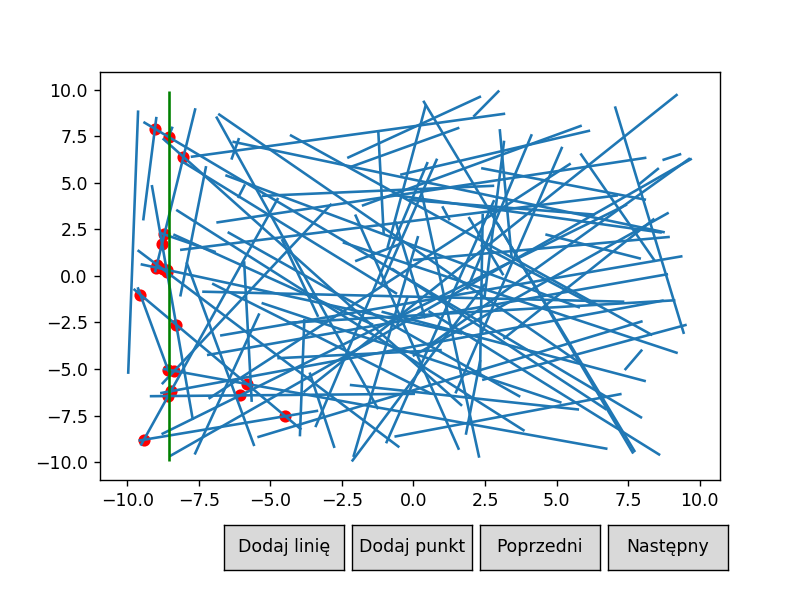

In [40]:
scenes = sweepVisualize(lines)


plot = Plot(scenes)
plot.draw()